In [1]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE57nnn/GSE57475/matrix/GSE57475_series_matrix.txt.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE18nnn/GSE18838/matrix/GSE18838_series_matrix.txt.gz


--2026-02-06 07:13:19--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE57nnn/GSE57475/matrix/GSE57475_series_matrix.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28146276 (27M) [application/x-gzip]
Saving to: ‘GSE57475_series_matrix.txt.gz.1’

GSE57475_series_mat 100%[===================>]  26.84M  7.23MB/s    in 3.7s    

2026-02-06 07:13:25 (7.23 MB/s) - ‘GSE57475_series_matrix.txt.gz.1’ saved [28146276/28146276]

--2026-02-06 07:13:25--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE18nnn/GSE18838/matrix/GSE18838_series_matrix.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.12, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [25]:
import pandas as pd
import gzip
from io import StringIO

def load_geo_series_matrix(path):
    with gzip.open(path, 'rt') as f:
        lines = f.readlines()

    start, end = None, None
    for i, line in enumerate(lines):
        if line.startswith("!series_matrix_table_begin"):
            start = i + 1
        elif line.startswith("!series_matrix_table_end"):
            end = i
            break

    data = ''.join(lines[start:end])
    df = pd.read_csv(StringIO(data), sep="\t", index_col=0)
    return df



In [26]:
path = "/workspaces/Reasearch_Genomic/GSE18838_series_matrix.txt.gz.1"

df = load_geo_series_matrix(path)

print("Original shape:", df.shape)


Original shape: (17881, 28)


In [27]:
X = df.T
print("After transpose:", X.shape)


After transpose: (28, 17881)


In [28]:
import numpy as np

y = np.zeros(X.shape[0])
y[: X.shape[0] // 2] = 1   # first half = class 1


In [29]:
# Force numeric
X = X.apply(pd.to_numeric, errors="coerce")

# Replace NaN / inf
X = X.fillna(0)


In [30]:
print(X.dtypes.unique())


[dtype('float64')]


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled.shape)


(28, 17881)


In [32]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    max_iter=5000,
    C=1.0
)

lasso.fit(X_scaled, y)


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l1'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass`

In [33]:
import numpy as np

coef = lasso.coef_[0]
importance = np.abs(coef)

genes = X.columns.to_numpy()

lasso_results = pd.DataFrame({
    "Gene": genes,
    "Coefficient": coef,
    "Importance": importance
})


In [34]:
top_32 = (
    lasso_results[lasso_results["Importance"] > 0]
    .sort_values(by="Importance", ascending=False)
    .head(32)
)

top_32


,Gene,Coefficient,Importance
2638,2569649,-0.159453,0.159453
11207,3474815,-0.128850,0.128850
14690,3811339,-0.128808,0.128808
5013,2845417,0.116027,0.116027
13984,3744410,-0.113208,0.113208
6621,3022409,-0.111853,0.111853
1020,2400655,-0.110776,0.110776
14366,3770328,-0.100428,0.100428
10426,3413067,-0.091836,0.091836
16735,3937967,0.086763,0.086763


In [35]:
top_32.to_csv("GSE18838_Top32_LASSO.csv", index=False)
print("Saved: GSE18838_Top32_LASSO.csv")


Saved: GSE18838_Top32_LASSO.csv


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)


(22, 17881) (6, 17881)


In [38]:
%pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 18.0 MB/s  0:00:19m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 37.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 33.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 34.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 36.4 MB/s  0:00:00m0:00:0100:01
   ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/25 [libclang]  WARNING: The script wheel is installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 11/25 [ml_dtypes]]-data-server]  WARNING: The script markdo

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


2026-02-06 07:30:15.175858: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-06 07:30:17.382241: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 07:30:21.025446: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [40]:
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-06 07:30:37.504226: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     2,288,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,297,217 (8.76 MB)

 Trainable params: 2,297,217 (8.76 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.5000 - loss: 1.3762 - val_accuracy: 0.3333 - val_loss: 2.2999
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7273 - loss: 1.3266 - val_accuracy: 0.3333 - val_loss: 5.8546
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8182 - loss: 2.1178 - val_accuracy: 0.5000 - val_loss: 7.8591
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9091 - loss: 1.2559 - val_accuracy: 0.5000 - val_loss: 8.5383
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8182 - loss: 4.5933 - val_accuracy: 0.5000 - val_loss: 12.2524
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9091 - loss: 1.4245 - val_accuracy: 0.6667 - val_loss: 14.8492
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9545 - loss: 0.0775 - val_accuracy: 0.6667 - val_loss: 17.2614
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9091 - loss: 1.2115 - val_accuracy: 0.6667 - val_loss: 16.

In [42]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")


Validation Accuracy: 0.5000
Validation Loss: 18.2004


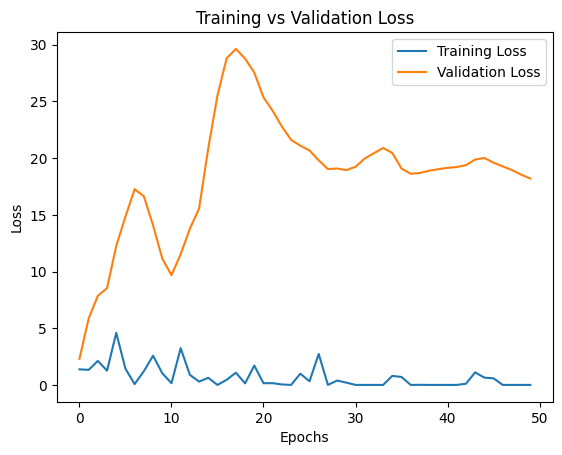

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


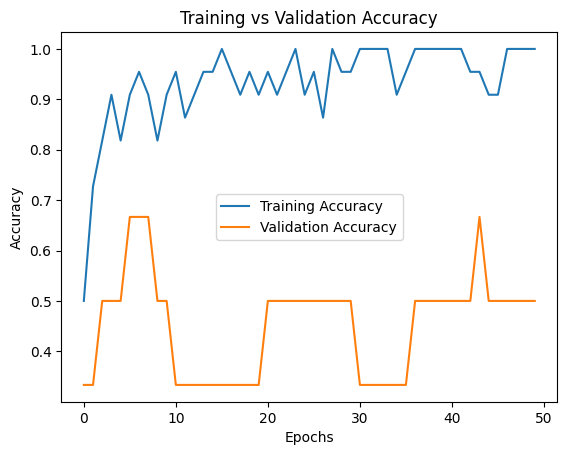

In [44]:
plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [45]:
path = "/workspaces/Reasearch_Genomic/GSE57475_series_matrix.txt.gz.1"

df = load_geo_series_matrix(path)
print("Original shape:", df.shape)


Original shape: (48766, 142)


In [46]:
X = df.T
print("After transpose:", X.shape)


After transpose: (142, 48766)


In [47]:
import numpy as np

y = np.zeros(X.shape[0])
y[: X.shape[0] // 2] = 1


In [48]:
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(0)

print(X.dtypes.unique())


[dtype('float64')]


In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled.shape)


(142, 48766)


In [50]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    max_iter=5000,
    C=1.0
)

lasso.fit(X_scaled, y)


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l1'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass`

In [51]:
import pandas as pd
import numpy as np

coef = lasso.coef_[0]
importance = np.abs(coef)
genes = X.columns.to_numpy()

lasso_df = pd.DataFrame({
    "Gene": genes,
    "Coefficient": coef,
    "Importance": importance
})


In [52]:
top_32 = (
    lasso_df[lasso_df["Importance"] > 0]
    .sort_values(by="Importance", ascending=False)
    .head(32)
)

top_32


,Gene,Coefficient,Importance
47132,ILMN_2359029,0.061847,0.061847
10453,ILMN_1702197,0.056195,0.056195
610,ILMN_1653712,0.054481,0.054481
30805,ILMN_1834190,0.052682,0.052682
28419,ILMN_1813833,-0.052185,0.052185
13997,ILMN_1722738,-0.052133,0.052133
47986,ILMN_2390310,0.049827,0.049827
15496,ILMN_1731720,-0.048428,0.048428
4642,ILMN_1672165,0.048085,0.048085
9515,ILMN_1696974,0.047849,0.047849


In [53]:
top_32.to_csv("GSE57475_Top32_LASSO.csv", index=False)
print("Saved: GSE57475_Top32_LASSO.csv")


Saved: GSE57475_Top32_LASSO.csv


In [54]:
selected_genes = top_32["Gene"].values
X_lasso = X[selected_genes]


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_lasso,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss


In [58]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    batch_size=16,
    learning_rate_init=0.001,
    max_iter=1,
    warm_start=True,
    random_state=42
)


In [59]:
epochs = 50

train_losses, val_losses = [], []
train_acc, val_acc = [], []

for _ in range(epochs):
    mlp.fit(X_train_scaled, y_train)

    y_train_pred = mlp.predict(X_train_scaled)
    y_val_pred = mlp.predict(X_val_scaled)

    y_train_prob = mlp.predict_proba(X_train_scaled)
    y_val_prob = mlp.predict_proba(X_val_scaled)

    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

    train_losses.append(log_loss(y_train, y_train_prob))
    val_losses.append(log_loss(y_val, y_val_prob))


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3

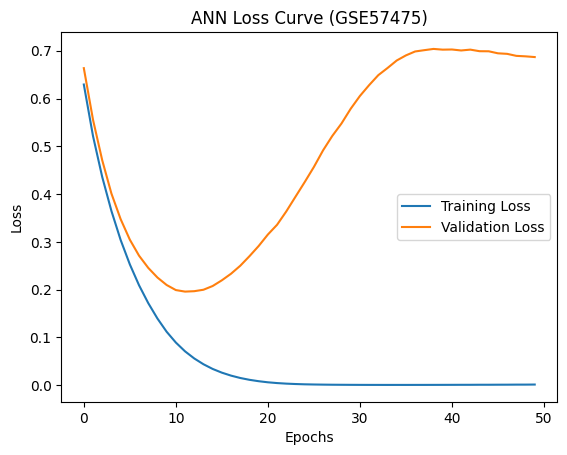

In [60]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Loss Curve (GSE57475)")
plt.legend()
plt.show()


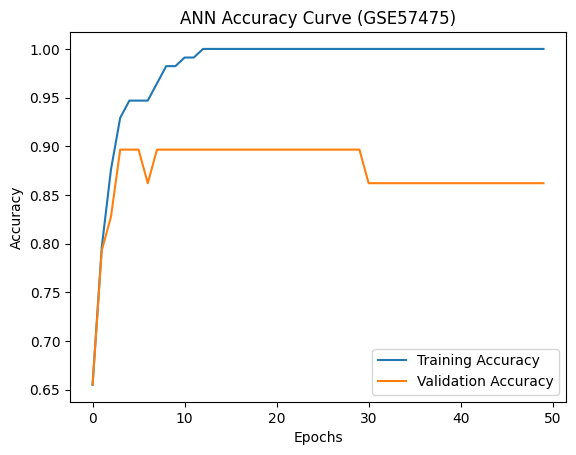

In [61]:
plt.figure()
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ANN Accuracy Curve (GSE57475)")
plt.legend()
plt.show()
